这是GPU计算SPEI的验证性质脚本

In [30]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
import torch
import xarray as xr
import dask as dk
import multiprocessing as mp
import os
import rasterio as rio
import rioxarray as rxr
import time
from numpy import inf
import lmoments3 as lm
from lmoments3 import distr
from numba_stats import norm
import climate_indices as ci
from climate_indices import indices

/home/zyzh0/anaconda3/envs/gis/lib/python3.11/site-packages/climate_indices/utils.py:148: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit
/home/zyzh0/anaconda3/envs/gis/lib/python3.11/site-packages/climate_indices/utils.py:198: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit
/home/zyzh0/anaconda3/envs/gis/lib/python3.11/site-packages/climate_in

检测CUDA状态并设置默认设备

In [35]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
else:
    torch.set_default_device('cpu')

读入示例数据

In [32]:

def read_precip():
    data_frame_list = []    
    for i in os.listdir(os.path.join("..","..","..","scripts/outputs/PRECIP")):
        filename  = os.path.join("..","..","..","scripts/outputs/PRECIP",i)
        data_frame = xr.open_dataset(filename,decode_coords="all").to_array()[0,:,:,:]
        data_frame_list.append(data_frame)
    return np.concatenate(data_frame_list,axis=0)

def read_pet():
    data_frame_list = []
    for i in os.listdir(os.path.join("..","..","..","scripts","outputs","PET")):
        data_frame_list.append(xr.open_dataset(os.path.join("..","..","..","scripts","outputs","PET",i),decode_coords="all").to_array())
    return np.concatenate(data_frame_list,axis=0)

In [33]:
pre_frame = read_precip()[0:192,:,:]*0.1
pet_frame = read_pet()

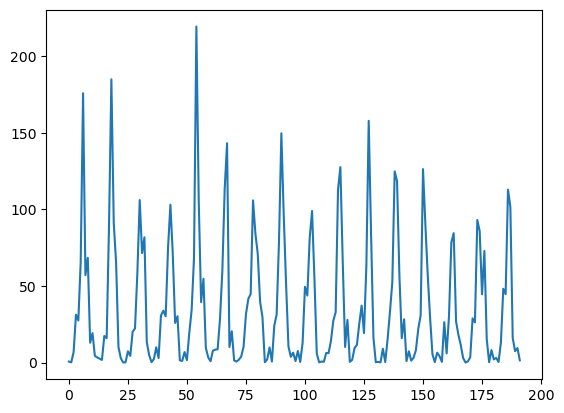

In [58]:
plt.plot(pre_frame[:,500,500])

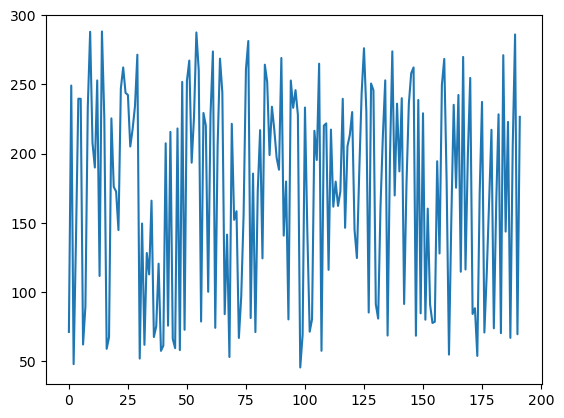

In [57]:
plt.plot(pet_frame[:,500,500])

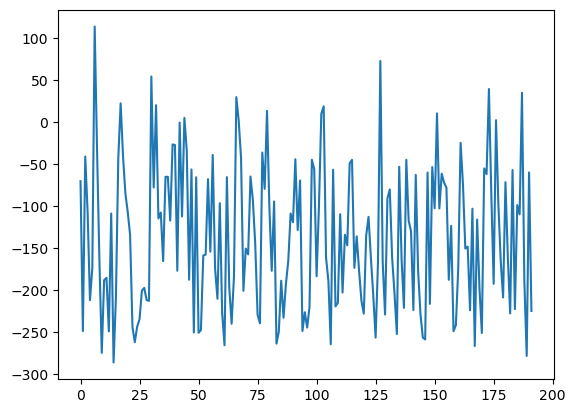

In [61]:
plt.plot(pre_frame[:,500,500]-pet_frame[:,500,500])

In [38]:
print(pre_frame.shape)
print(pet_frame.shape)

(192, 1800, 1560)
(192, 1800, 1560)


In [34]:
d_frame=pre_frame-pet_frame

In [35]:
d_seq  = d_frame[:,500,500]

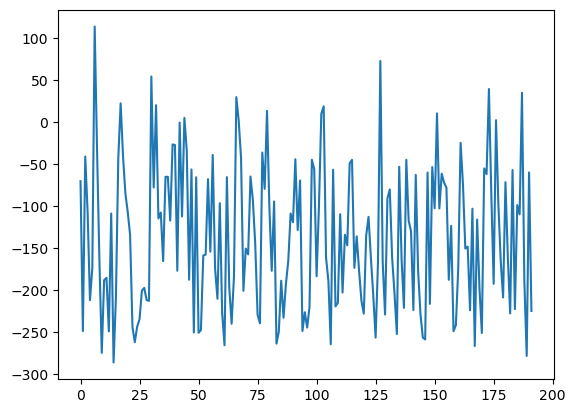

In [64]:
plt.plot(d_seq)

In [41]:
time_start = time.time()
lm_gev_para = distr.gev.lmom_fit(d_seq)
time_end = time.time()
print("Time used: ",time_end-time_start)

Time used:  0.0017991065979003906


In [42]:
print(lm_gev_para)

OrderedDict([('c', 0.15344439237098156), ('loc', -173.07769371741585), ('scale', 80.47461026095075)])


In [43]:
lm_dist = distr.gev(**lm_gev_para)
lm_ppf = np.linspace(lm_dist.ppf(0.01),lm_dist.ppf(0.99))

In [44]:
time_start=time.time()
def get_lm_paras(d_seq):
    lm_est = lm.lmom_ratios(d_seq,3)
    kappa = (0.488138*lm_est[2]**1.70839)-(1.7631*lm_est[2]**0.981824)+0.285706
    alpha = (1.023602813*lm_est[2]**1.8850974-2.95087636*lm_est[2]**1.195591244+1.759614982)*lm_est[1]
    zeta = (-0.0937*lm_est[2]**4-0.2198*lm_est[2]**3+1.407*lm_est[2]**2-1.4825*lm_est[2]-0.6205)*lm_est[1]+lm_est[0]
    return [kappa,zeta,alpha]

lm_para=get_lm_paras(d_seq)
time_end=time.time()
print('totally cost',time_end-time_start)

totally cost 0.0009186267852783203


In [45]:
time_start=time.time()
mle_paras = sp.stats.genextreme.fit(d_seq)
time_end=time.time()
print('totally cost',time_end-time_start)

totally cost 0.11337637901306152


(-287.0, 114.0)

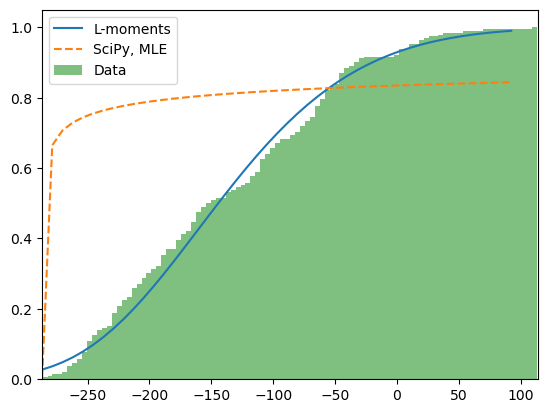

In [46]:
plt.plot(lm_ppf,lm_dist.cdf(lm_ppf),label="L-moments")
plt.plot(lm_ppf,sp.stats.genextreme.cdf(lm_ppf,*mle_paras),label="SciPy, MLE",linestyle="--")
plt.hist(d_seq,bins=100,density=True,label="Data",cumulative=True,color="green",alpha=0.5)
plt.legend()
plt.xlim(-287,114)

In [53]:
prob_seq = lm_dist.cdf(d_seq)
norm_seq = norm.ppf(prob_seq,loc=0,scale=1)

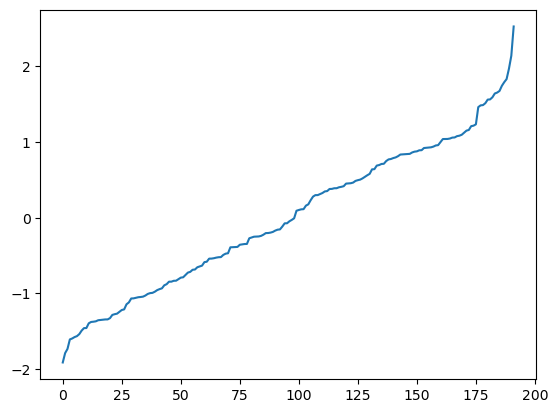

In [54]:
plt.plot(norm_seq)

In [47]:
def samlmusmall(x, nmom=5):
    try:
        x = np.asarray(x, dtype=np.float64)
        n = x.shape[0]
        x.sort(axis=0)
    except ValueError:
        raise ValueError("Input data to estimate L-moments must be numeric.")

    if nmom <= 0 or nmom > 5:
        raise ValueError("Invalid number of sample L-moments")

    if n < nmom:
        raise ValueError("Insufficient length of data for specified nmoments")

    # First L-moment

    l1 = np.sum(x,axis=0) / sp.special.comb(n, 1, exact=True)

    if nmom == 1:
        return l1

    # Second L-moment

    comb1 = range(n)
    coefl2 = 0.5 / sp.special.comb(n, 2, exact=True)
    sum_xtrans = sum([(comb1[i] - comb1[n - i - 1]) * x[i] for i in range(n)])
    l2 = coefl2 * sum_xtrans

    if nmom == 2:
        return [l1, l2]

    # Third L-moment

    comb3 = [sp.special.comb(i, 2, exact=True) for i in range(n)]
    coefl3 = 1.0 / 3.0 / sp.special.comb(n, 3, exact=True)
    sum_xtrans = sum(
        [
            (comb3[i] - 2 * comb1[i] * comb1[n - i - 1] + comb3[n - i - 1]) * x[i]
            for i in range(n)
        ]
    )
    l3 = coefl3 * sum_xtrans / l2

    if nmom == 3:
        return [l1, l2, l3]

    # Fourth L-moment

    comb5 = [sp.special.comb(i, 3, exact=True) for i in range(n)]
    coefl4 = 0.25 / sp.special.comb(n, 4, exact=True)
    sum_xtrans = sum(
        [
            (
                comb5[i]
                - 3 * comb3[i] * comb1[n - i - 1]
                + 3 * comb1[i] * comb3[n - i - 1]
                - comb5[n - i - 1]
            )
            * x[i]
            for i in range(n)
        ]
    )
    l4 = coefl4 * sum_xtrans / l2

    if nmom == 4:
        return [l1, l2, l3, l4]

    # Fifth L-moment

    comb7 = [sp.special.comb(i, 4, exact=True) for i in range(n)]
    coefl5 = 0.2 / sp.special.comb(n, 5, exact=True)
    sum_xtrans = sum(
        [
            (
                comb7[i]
                - 4 * comb5[i] * comb1[n - i - 1]
                + 6 * comb3[i] * comb3[n - i - 1]
                - 4 * comb1[i] * comb5[n - i - 1]
                + comb7[n - i - 1]
            )
            * x[i]
            for i in range(n)
        ]
    )
    l5 = coefl5 * sum_xtrans / l2

    return [l1, l2, l3, l4, l5]

In [50]:
def genextreme_cdf(x, c, loc=0, scale=1):
    # Use the general formula
    z = 1 - c * (x - loc) / scale
    return np.exp(-z ** (1 / c))

In [18]:
spei = xr.open_dataset("../../../scripts/outputs/SPEI/spei.nc")

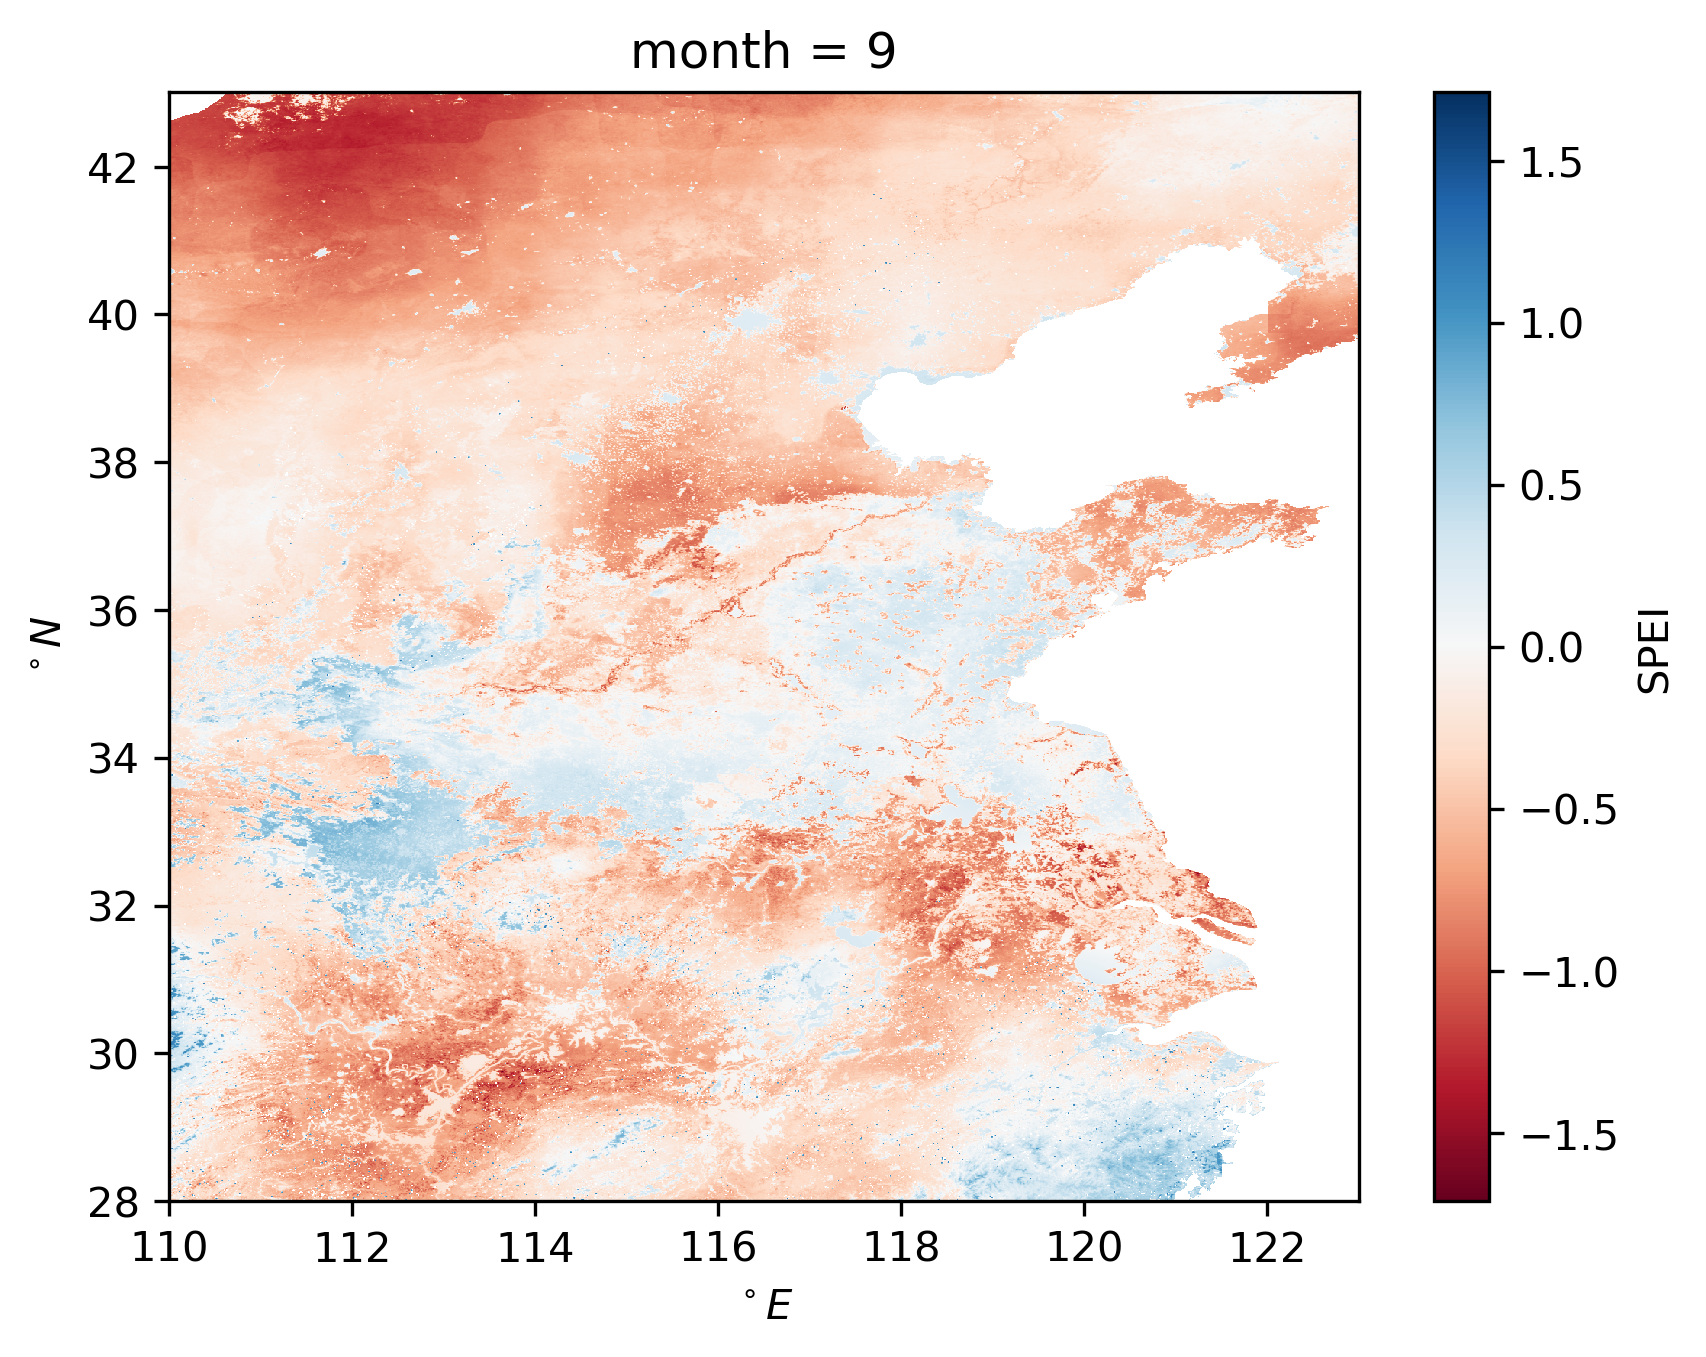

In [60]:
sf=spei.loc[dict(month=9)]
fig, ax = plt.subplots()
sf.spei.plot(ax=ax,cmap='RdBu',cbar_kwargs={'label':'SPEI'})
ax.set_xlabel('$^\circ E$')
ax.set_ylabel('$^\circ N$')
fig.dpi=300

In [4]:
spei_array = spei.to_array()[0]

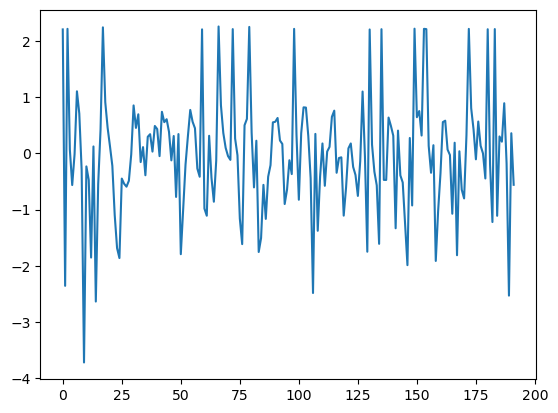

In [29]:
plt.plot(spei_array[:,600,600])

In [43]:
fisk_para = sp.stats.fisk.fit(spei_array[:,600,600])

In [44]:
p = 1-sp.stats.fisk.cdf(spei_array[:,600,600],*fisk_para)

In [45]:

def standardize_p(p):
    spei_lst = []
    c0,c1,c2,d1,d2,d3 = 2.515517,0.802853,0.010328,1.432788,0.189269,0.001308
    for i in p:
        if i <= 0.5:
            w = np.sqrt(-2*np.log(i))
            spei = w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3))
        elif i > 0.5:
            w = np.sqrt(-2*np.log(1-i))
            spei = -(w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3)))
        spei_lst.append(spei)
    return np.array(spei_lst)

In [46]:
spei_fisk = standardize_p(p)

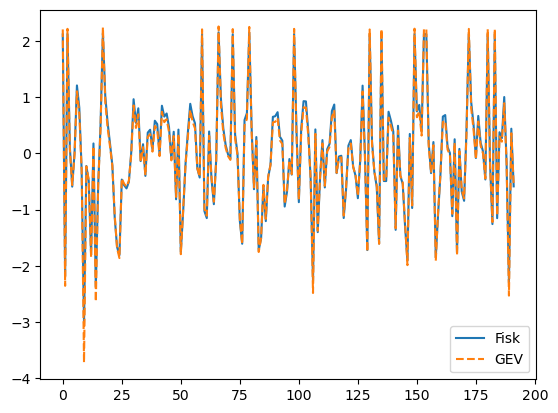

In [51]:
plt.plot(spei_fisk,label="Fisk")
plt.plot(spei_array[:,600,600],linestyle="--",label="GEV")
plt.legend()